In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt
from metpy.interpolate import interpolate_to_points
import scipy.optimize as spo
import time 

In [2]:
# creating the pulse field

def gen_field(dur_max, dur_step):
    pdur_i0 = ppau_i0 = np.arange(0, dur_max, dur_step)
    pdur_j, ppau_j = np.meshgrid(pdur_i0, ppau_i0)
    return pdur_j, ppau_j


In [3]:
#Plotting the data

def plot_field(pdur, ppau, res):
    plt.pcolor(pdur, ppau, res, cmap='Reds')
    plt.xlim(0, np.max(pdur))
    plt.ylim(0, np.max(ppau))
    plt.colorbar(label='Phonotaxis')
    plt.xlabel('Pulse [ms]')
    plt.ylabel('Pause [ms]')
    plt.show()

In [4]:
#Importing data from file

def import_data():
    df = np.genfromtxt('dat/G14.txt', delimiter = ',', usecols= (8,9,11), skip_header = 1)
    check = df<=80
    df_c = np.all(check,1)
    df = df[df_c]

    df = np.append(df, [[0, 20, 0] , [20, 20, 0], [0,0,0], [20,0,0]], axis = 0)
    
    df = df.T
    pdur = df[0]
    ppau = df[1]
    phonotaxis = df[2]
    
    dur_max = 20  # ms
    dur_step = 0.5  # ms

    np.random.seed(10)
    # need to jitter data points slightly for interp to work - probably a bug in metpy
    points = np.array([pdur + np.random.randn(*pdur.shape)/10000000, ppau + np.random.randn(*ppau.shape)/10000000]).T

    # make new grid of points to interpolate to
    pdur_i0 = ppau_i0 = np.arange(0, dur_max, dur_step)
    pdur_i, ppau_i = np.meshgrid(pdur_i0, ppau_i0)
    new_points = np.array([pdur_i, ppau_i]).T.reshape((-1, 2))

    # natural neighbour interpolation 
    ppf = interpolate_to_points(points, phonotaxis, new_points, interp_type='natural_neighbor')
    ppf[np.isnan(ppf)] = np.nanmean(ppf)
    ppf = np.maximum(ppf, 0)  # set neg vals to 0
    ppf = ppf.reshape((len(pdur_i), len(ppau_i))).T  # make interpolated ppf square
    
    ppf /= np.max(ppf)
    
    return ppf


In [5]:
#defining some global variables that are constant and used throughout the code

pnt_ori = import_data() # ms
dur_max = 20
dur_step = 0.5  # ms
global pnt_ori, pdur_i, ppau_i

pnt_ori /= np.max(pnt_ori)
# print(pnt_ori)
pdur_i, ppau_i = gen_field(dur_max, dur_step)

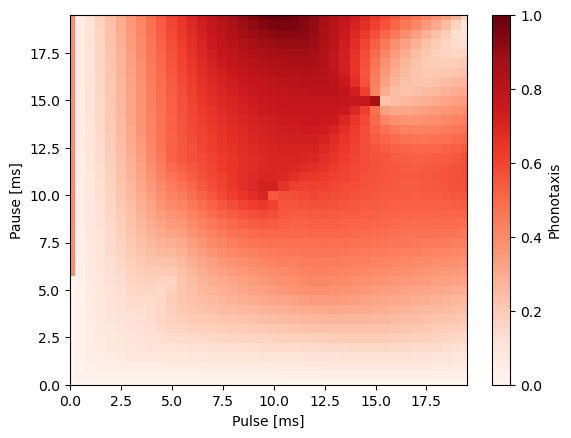

In [6]:
#For reference
plot_field(pdur_i, ppau_i, pnt_ori)

In [7]:
#generating the signal from the parameter duty cycle

def signal(idur, ipau, sf):
    sf = int(sf)
    unit = (sf/1000)
    dur = int(unit*idur)
    pau = int(unit*ipau)
    #print(dur, pau, unit)
    adur = np.ones(dur, dtype = int)
    apau = np.zeros(pau, dtype = int)
    aper = np.concatenate((adur,apau))
    sig2 = np.tile(aper, sf)
    if len(sig2)>sf:
        sig = sig2[0:sf]
    else:
        l = sf - len(sig2)
        sig3 = np.zeros(l, dtype = int)
        sig = np.concatenate((sig2, sig3))
    return sig

In [22]:
#The Gabor filter

def gabor(fr, sigma, phi, w, sf):
    border = int((3.5*sigma)) 
    t =  np.arange(-border, border, 1000/sf) #in ms
    gaussian = np.exp(-(t)**2/(2*sigma**2)) # in ms
    sinusoidal = np.sin(2*np.pi*(fr/1000)*t + phi) # in KHz, ms
    gbr =  gaussian * sinusoidal + w
    return gbr


In [9]:
#linear nonlinear filtering (including the integration)

def lin_nonlin(sig, gab, a1, b1):
    f1 = np.convolve(sig, gab) #linear filter
    
    g1 = 1/(1 + np.exp( -(a1 * f1) + b1)) # nonlinear sigmoid function

    #integral (which is basically summation)
    v1 = 0.001 * g1.sum()
    return v1

In [10]:
#extracting Phonotaxis value by pushing fabricated signal through filter

def phonotaxis(fr, sigma, phi, w, a1, b1, sf, t1, t2):
    sig1 = signal(t1, t2, sf)
    gab1 = gabor(fr, sigma, phi, w, sf)
    phntxs = lin_nonlin(sig1, gab1, a1, b1)
    return phntxs


In [11]:
#the entire model as a single function which is to be minimized 
#the function calculates the difference between the generated pulse-pause preference data and the actual experimental data imported earlier in the program.

def sig_diff(cfg):
    fr, sigma, ph, w, a1, b1 = cfg #unpacking the command from gods
    phi = np.pi * ph

    #generate field
    sf = 2000
    
    #calculating phonotaxis values
    phono = np.vectorize(phonotaxis)
    pnt = phono(fr, sigma, phi, w, a1, b1, sf, pdur_i, ppau_i)
    
    #normalization
    pnt = np.maximum(pnt, 0)
    if (np.max(pnt) - np.min(pnt)) > 0:
        pnt = (pnt - np.min(pnt))/(np.max(pnt) - np.min(pnt))
    else:
        pnt = (pnt - np.min(pnt))
    #RMS of difference
    diff = np.sqrt(np.mean((pnt - pnt_ori)**2))
    
    return diff

In [12]:
#redundant function for crossverification and plotting

def sig_diff2(cfg):
    fr, sigma, ph, w, a1, b1 = cfg #unpacking the command from gods
    phi = np.pi * ph

    #generate field
    sf = 2000
    
    #calculating phonotaxis values
    phono = np.vectorize(phonotaxis)
    pnt = phono(fr, sigma, phi, w, a1, b1, sf, pdur_i, ppau_i)
    
    #normalization
    pnt = np.maximum(pnt, 0)
    if (np.max(pnt) - np.min(pnt)) > 0:
        pnt = (pnt - np.min(pnt))/(np.max(pnt) - np.min(pnt))
    else:
        pnt = (pnt - np.min(pnt))
    #RMS of difference
    diff = np.sqrt(np.mean((pnt - pnt_ori)**2))
    
    return diff, pnt

0.20582588104847485


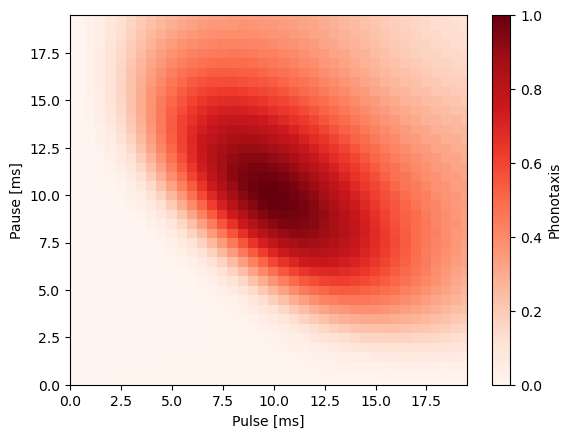

In [13]:
#setting initial values. and printing the start point of the minimize function present below
cfg = [50, 10, 0, 0, 0.02, 1]
y = sig_diff(cfg)
print(y)
xz = sig_diff2(cfg)
plot_field(pdur_i, ppau_i, xz[1])

In [25]:
#bounds of each parameter

b_fr = (0, 300)
b_sigma = (1, 201)
b_phi = (0, 2)
b_w = (-0.3, 0.3)
b_a1 = (0, np.inf)
b_b1 = (-np.inf, np.inf)

bnds = (b_fr, b_sigma, b_phi, b_w, b_a1, b_b1) #, b_dur_max, b_dur_step) #if necessary 


#Basin hopping minimization - to find the closest fit with the existing data without getting stuck in a local minima. , 'maxfev':1500  'options' : {"disp": True},  'bounds' : bnds, 
result = spo.basinhopping(sig_diff, cfg, niter = 10, minimizer_kwargs={'options' : {"disp": True}, 'bounds' : bnds,  'method' : 'L-BFGS-B'})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.05826D-01    |proj g|=  3.00000D-01

At iterate    1    f=  2.00734D-01    |proj g|=  8.25541D-01

At iterate    2    f=  1.97232D-01    |proj g|=  3.00688D-01

At iterate    3    f=  1.97045D-01    |proj g|=  2.99431D-01

At iterate    4    f=  1.97034D-01    |proj g|=  3.31285D-02

At iterate    5    f=  1.97034D-01    |proj g|=  2.15467D-02

At iterate    6    f=  1.97034D-01    |proj g|=  2.08983D-02

At iterate    7    f=  1.97034D-01    |proj g|=  7.28312D-02

At iterate    8    f=  1.97034D-01    |proj g|=  1.47578D-01

At iterate    9    f=  1.97033D-01    |proj g|=  2.75016D-01

At iterate   10    f=  1.97031D-01    |proj g|=  2.99415D-01

At iterate   11    f=  1.97025D-01    |proj g|=  2.99413D-01

At iterate   12    f=  1.97009D-01    |proj g|=  2.99401D-01

At iterate   13    f=  1.9


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/tmp/ipykernel_13655/901067433.py:6: RuntimeWarning: overflow encountered in exp
  g1 = 1/(1 + np.exp( -(a1 * f1) + b1)) # nonlinear sigmoid function



At iterate   50    f=  2.05517D-01    |proj g|=  5.10164D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50    165     50     1     0   5.102D-02   2.055D-01
  F =  0.20551749127922864     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  4.12407D-01    |proj g|=  7.62840D-01

At iterate    1    f=  2.11278D-01    |proj g|=  1.50249D-01

At iterate    2    f=  2.10546D-01    |proj g|=  3.28790D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  2.10461D-01    |proj g|=  2.57092D-02

At iterate   11    f=  2.10459D-01    |proj g|=  2.22096D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     99     15     1     0   2.221D-02   2.105D-01
  F =  0.21045936291372905     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.52597D-01    |proj g|=  2.94243D-01

At iterate    1    f=  2.40035D-01    |proj g|=  6.26589D-01

At iterate    2    f=  2.26138D-01    |proj g|=  5.22142D-01

At iterate    3    f=  2.20842D-01    |proj g|=  3.96100D-01

At iterate    4    f=  2.09557D-01    |proj g|=  3.71252D-01

At iterate    5    f=  2.09070D-01    |proj g|=  3.31087D-01

At iterate    6    f=  2.08053D-01    |proj g|=  2.45364D-01

At iterate    7    f=  2.07153D-01    |proj g|=  5.16677D-02

At iterate    8    f=  2.07131D-01    |proj g|=  2.31477D-02

At iterate    9    f=  2.07081D-01    |proj g|=  3.72297D-02

At iterate   10    f=  2.07079D-01    |proj g|=  2.68168D-02

At iterate   11    f=  2.07067D-01    |proj g|=  2.37780D-02

At iterate   12    f=  2.07060D-01    |proj g|=  4.18721D-02

At iterate   13    f=  2.0


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   23    f=  2.05388D-01    |proj g|=  4.17041D-04

At iterate   24    f=  2.05388D-01    |proj g|=  4.14627D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     81     26     2     1   4.146D-04   2.054D-01
  F =  0.20538826565261056     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  3.68597D-01    |proj g|=  6.00000D-01

At iterate    1    f=  2.16061D-01    |proj g|=  4.37760D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   28    f=  2.08902D-01    |proj g|=  9.65619D-02

At iterate   29    f=  2.08880D-01    |proj g|=  6.02795D-02

At iterate   30    f=  2.08874D-01    |proj g|=  1.76303D-02

At iterate   31    f=  2.08873D-01    |proj g|=  1.29207D-02

At iterate   32    f=  2.08872D-01    |proj g|=  1.59044D-02

At iterate   33    f=  2.08872D-01    |proj g|=  8.44086D-03

At iterate   34    f=  2.08871D-01    |proj g|=  2.18974D-03

At iterate   35    f=  2.08871D-01    |proj g|=  3.20613D-03

At iterate   36    f=  2.08871D-01    |proj g|=  5.50366D-03

At iterate   37    f=  2.08871D-01    |proj g|=  1.17975D-02

At iterate   38    f=  2.08871D-01    |proj g|=  2.05170D-02

At iterate   39    f=  2.08869D-01    |proj g|=  3.58994D-02

At iterate   40    f=  2.08866D-01    |proj g|=  5.96206D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   41    f=  2.08861D-01    |proj g|=  7.09891D-03

At iterate   42    f=  2.08861D-01    |proj g|=  4.55497D-03

At iterate   43    f=  2.08861D-01    |proj g|=  3.72616D-03

At iterate   44    f=  2.08861D-01    |proj g|=  3.18599D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f=  2.08861D-01    |proj g|=  2.69163D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46    196     51     0     0   2.692D-03   2.089D-01
  F =  0.20886057260212068     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  6.13956D-01    |proj g|=  1.78051D-01

At iterate    1    f=  6.13026D-01    |proj g|=  1.76282D-01

At iterate    2    f=  6.12865D-01    |proj g|=  1.75571D-01

At iterate    3    f=  6.12496D-01    |proj g|=  1.84953D-02

At iterate    4    f=  6.12298D-01    |proj g|=  9.75859D-02
  ys=-2.431E-05  -gs= 1.754E-04 BFGS update SKIPPED

At iterate    5    f=  6.12259D-01    |proj g|=  3.70722D-02

At iterate    6    f=  6.12251D-01    |proj g|=  1.28657D-02

At iterate    7    f=  6.12237D-01    |proj g|=  2.43835D-02

At iterate    8    f=  6.11939D-01    |proj g|=  7.61304D-02

At iterate    9    f=  6.11902D-01    |proj g|=  2.41626D-01

At iterate   10    f=  6.11068D-01    |proj g|=  3.84629D-01

At iterate   11    f=  4.09052D-01    |proj g|=  2.67877D-01
  ys=-2.175E-01  -gs= 6.529E-02 BFGS 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f=  2.69843D-01    |proj g|=  4.43283D-02

At iterate   16    f=  2.69826D-01    |proj g|=  4.30233D-02

At iterate   17    f=  2.69802D-01    |proj g|=  4.58083D-02

At iterate   18    f=  2.69755D-01    |proj g|=  3.48782D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   19    f=  2.69751D-01    |proj g|=  2.43707D-02

At iterate   20    f=  2.69750D-01    |proj g|=  2.13280D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21    170     26     1     0   2.133D-02   2.698D-01
  F =  0.26975016370025678     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  4.36803D-01    |proj g|=  7.08905D-02

At iterate    1    f=  4.30831D-01    |proj g|=  2.09685D-01
  ys=-9.844E-03  -gs= 5.072E-03 BFGS update SKIPPED

At iterate    2    f=  4.22545D-01    |proj g|=  5.95745D-02

At iterate    3  

In [15]:
# Example parameters for signal generation
# sf = 2000

# #PARAMETERS OF GABOR FUNCTION
# #frequency for the Gabor filter - INFLUENCES pulse period preference
# fr = 50 #in Hz
# #sharpness of tuning for pulse period
# sigma = 50 
# #phase shift - change the integer to change the phase 
# phi = np.pi * 0 
# #offset - INFLUENCES duty cycle preference
# w = 0

# #parameters for Lin_nonlinear
# a1 = 0.05 #slope/steepness of sigmoid
# b1 = 1 #1/2 of max of non linearity

# #pulse pause field sampling range and frequency(step)
# dur_max = 20  # ms
# dur_step = 0.5  # ms

In [16]:
# cfg1 = [1,0,0]
# vals = []
# for i in range(45, 55):
#     print(i)
#     for j in range(1, 50):
#         cfg = [j, i, 0, 0, 0.05, 1]
#         x = sig_diff(cfg)
#         vals.append(x)
#         if cfg1[0] > x:
#             cfg1 = [x, i, j]
    
# print(cfg1)
# plt.plot(vals)
# plt.show()

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.15318351844879854
                          x: [ 4.908e+01  8.698e+00  3.916e-02 -1.337e-03
                               1.753e-03  1.255e+00]
                        nit: 10
      minimization_failures: 3
                       nfev: 7812
                       njev: 1116
 lowest_optimization_result:  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
                              success: True
                               status: 0
                                  fun: 0.15318351844879854
                                    x: [ 4.908e+01  8.698e+00  3.916e-02
                                        -1.337e-03  1.753e-03  1.255e+00]
                                  nit: 28
                                  jac: [ 2.756e-03  1.451e-03  2.395e-03
                                         9.295e-02  5.752e-03  2.1

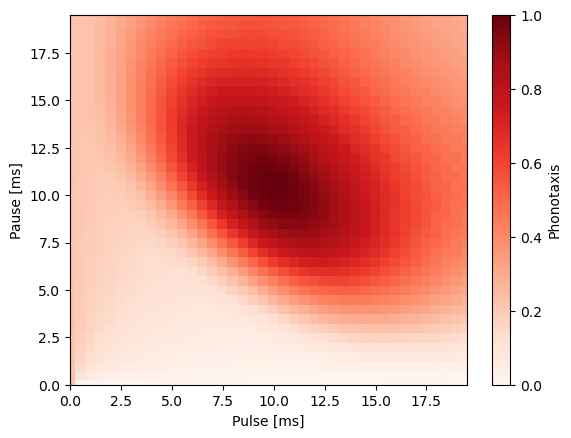

In [26]:
#Printing the result and the closest fit result generated from the model. 

print(result)
xe = sig_diff2(result.x)
plot_field(pdur_i, ppau_i, xe[1])